In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable

torch.manual_seed(0)

In [2]:
# Keep results
RMSE=list()
MPE=list()

In [3]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData.csv')

#Scale Cell life target Values
Dataset['cell_life']=np.log10(Dataset['cell_life'])

numBat1=41
numBat2=43
numBat3=40
numBat=124
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
test_edited_ind = np.delete(test_ind, 21) # Remove battery 
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_100_10']

dismod_features=['minimum_dQ_100_10',
                 'variance_dQ_100_10',
                 'skewness_dQ_100_10',
                 'kurtosis_dQ_100_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_100_10',
               'variance_dQ_100_10',
               'Slope_Cap_Fade_2_100',
               'Intercept_Cap_Fade_2_100',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_100',
               'Min_IR',
               'Diff_IR_2_100']

In [4]:
#Use only the discharge model Tabular features
features = dismod_features #full_features
X_train=Training_Data[features].to_numpy()
X_test=Testing_Data[features].to_numpy()
X_sec=Secondary_Data[features].to_numpy()

#Scale
scaler = preprocessing.StandardScaler().fit(X_train)
Tabular_Train = scaler.transform(X_train)
Tabular_test = scaler.transform(X_test)
Tabular_sec = scaler.transform(X_sec)

In [5]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(1.0000, dtype=torch.float64) tensor(-0.6982, dtype=torch.float64)
tensor(0.8786, dtype=torch.float64) tensor(-0.6188, dtype=torch.float64)
tensor(0.4862, dtype=torch.float64) tensor(-0.3183, dtype=torch.float64)
torch.Size([41, 100, 99])
torch.Size([42, 100, 99])
torch.Size([40, 100, 99])


In [6]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, features, targets, tabular):
        self.features = features
        self.targets = targets
        self.tabular = tabular #Merge tabular data set
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.tabular[idx]
  
    def __len__(self):
        return len(self.features)

In [8]:
class CNN(nn.Module):

    def __init__(self,inputSize):
        
        super(CNN, self).__init__()
        self.firstEpochFlag=True
        # Calculates size of first linear layer 
        # This allows the Module to be used with different number of cycles
        self.linearSize=((((inputSize-2)//2)-2)//2)*23*16#+6
        
        self.convolutional_layer = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3,3)),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(self.linearSize,120),
            #nn.Dropout(.1)
            nn.ReLU(),
            nn.Linear(120,84),  
            nn.ReLU(),
            nn.Linear(84,1),
        )

    def forward(self, x,tabular):
        #Print the shapes of the data on the first Epoch
        if(self.firstEpochFlag):print(x.shape)
        
        x = x.view(-1, 1,x.shape[1],99)
        if(self.firstEpochFlag):print(x.shape)
        
        clout = self.convolutional_layer(x)
        if(self.firstEpochFlag):print(clout.shape)
        
        flat = torch.flatten(clout, 1)
        if(self.firstEpochFlag):print(flat.shape)
            
        #Concatenate tabular features!
        #flat=torch.cat((flat, tabular), -1)
        if(self.firstEpochFlag):
            print(tabular.shape)
            print(flat.shape)
            self.firstEpochFlag=False
           
        output = self.linear_layer(flat)
        return output

In [9]:
def train(model,train_loader,criterion,optimizer,epochs,device):
    for epoch in range(epochs):
        model.train()
        for inputs, targets, tabular in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            tabular = tabular.to(device)
            
            outputs = model(inputs,tabular)
            outputs.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        model.eval()
        if(epoch%100 == 0):
            print('--',epoch,'-epoch--RMSE-- ',
                  np.sqrt(mean_squared_error(10**(targets.cpu().detach().numpy()+y_train_mean.numpy()), 
                                          10**(outputs.cpu().detach().numpy()+y_train_mean.numpy()))))
    return model

In [10]:
def testALL(model):
    dataloaders = [[train_Qdlin_loader,'---RMSE---Train','---MPE---Train',[],[]],
                   [test_Qdlin_loader,'---RMSE---Test','---MPE---Test',[],[]],
                   [secondary_test_Qdlin_loader,'---RMSE---Test Secondary','---MPE---Test Secondary',[],[]]]
    
    for dataloader in dataloaders:
        for inputs, targets,tabular in dataloader[0]:
            inputs = inputs.to(device)
            targets = targets.to(device)
            tabular = tabular.to(device)
            
            outputs = model(inputs,tabular)
            outputs.to(device)
            loss = criterion(outputs, targets)
            
            dataloader[3] = 10**(targets.cpu().detach().numpy()+y_train_mean.numpy()) # y Target Values
            dataloader[4] = 10**(outputs.cpu().detach().numpy()+y_train_mean.numpy()) # y Predicted Values
            
            RMSE_last_epoch = np.sqrt(mean_squared_error(dataloader[3],dataloader[4]))
            MPE_last_epoch = float(np.mean(np.abs( (dataloader[3]-dataloader[4]) / dataloader[3]* 100 )))
            
            print(RMSE_last_epoch,dataloader[1])
            print(MPE_last_epoch,dataloader[2])
            
            RMSE.append(int(RMSE_last_epoch))
            MPE.append(int(MPE_last_epoch))
    
    plt.figure(figsize=(5,5)) 
    plt.xlabel('Observed Cycle Life')
    plt.ylabel('Predicted Cycle Life')
    plt.scatter(x=dataloaders[0][3],y=dataloaders[0][4],marker='o',c='blue',s=100)
    plt.scatter(x=dataloaders[1][3],y=dataloaders[1][4],marker='s',c='red',s=100)
    plt.scatter(x=dataloaders[2][3],y=dataloaders[2][4],marker='^',c='orange',s=100)
    plt.xlim(0,2500)
    plt.ylim(0,2500)
    plt.plot(range(2500),c='black')
    plt.show()

In [11]:
torch.set_default_dtype(torch.float64)

In [12]:
train_Dataset = CustomDataset(train_Qdlin,y_train,Tabular_Train)
test_Dataset = CustomDataset(test_Qdlin,y_test,Tabular_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec,Tabular_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [13]:
epochs = 5000
learning_rate =.0001
weight_decay = .001

# Train & Test

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [15]:
criterion=nn.MSELoss()
model=CNN(100) #Using only the First 100 cycles
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=learning_rate)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 100, 99])
torch.Size([41, 1, 100, 99])
torch.Size([41, 16, 23, 23])
torch.Size([41, 8464])
torch.Size([41, 6])
torch.Size([41, 8464])
-- 0 -epoch--RMSE--  321.4547927417165
-- 100 -epoch--RMSE--  39.573802380668624
-- 200 -epoch--RMSE--  24.73552500202465
-- 300 -epoch--RMSE--  20.736994815318564
-- 400 -epoch--RMSE--  18.789554770304445
-- 500 -epoch--RMSE--  20.420912509518455
-- 600 -epoch--RMSE--  17.15395858378218
-- 700 -epoch--RMSE--  16.237756199120195
-- 800 -epoch--RMSE--  15.709246160697003
-- 900 -epoch--RMSE--  16.28152050659023
-- 1000 -epoch--RMSE--  22.60050985045368
-- 1100 -epoch--RMSE--  19.613080895061213
-- 1200 -epoch--RMSE--  15.539443883121544
-- 1300 -epoch--RMSE--  15.744183856498516
-- 1400 -epoch--RMSE--  15.663048298777904
-- 1500 -epoch--RMSE--  14.221633609932272
-- 1600 -epoch--RMSE--  15.529868528314326
-- 1700 -epoch--RMSE--  15.819033230071224
-- 1800 -epoch--RMSE--  13.638492870141308
-- 1900 -epoch--RMSE--  16.081652364358522
-- 2000

19.758519283661233 ---RMSE---Train
2.1159640215957256 ---MPE---Train
79.92665208311203 ---RMSE---Test
6.525256120424065 ---MPE---Test
209.71130342770138 ---RMSE---Test Secondary
9.658691196335088 ---MPE---Test Secondary


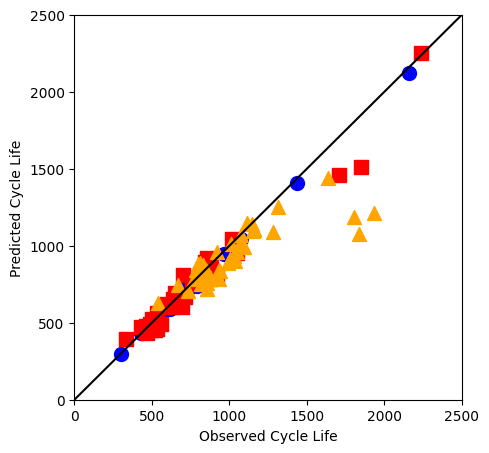

In [16]:
testALL(model)

################################################################################

# Repeat using only the first 60 cycles

################################################################################

In [17]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-60Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_60_10']

dismod_features=['minimum_dQ_60_10',
                 'variance_dQ_60_10',
                 'skewness_dQ_60_10',
                 'kurtosis_dQ_60_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_60_10',
               'variance_dQ_60_10',
               'Slope_Cap_Fade_2_60',
               'Intercept_Cap_Fade_2_60',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_60',
               'Min_IR',
               'Diff_IR_2_60']

In [18]:
#Use only the discharge model Tabular features
features = dismod_features #full_features
X_train=Training_Data[features].to_numpy()
X_test=Testing_Data[features].to_numpy()
X_sec=Secondary_Data[features].to_numpy()

#Scale
scaler = preprocessing.StandardScaler().fit(X_train)
Tabular_Train = scaler.transform(X_train)
Tabular_test = scaler.transform(X_test)
Tabular_sec = scaler.transform(X_sec)

In [19]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = train_Qdlin[:,:60,:]
test_Qdlin = test_Qdlin[:,:60,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,:60,:]

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(1.1621) tensor(-0.8226)
tensor(1.0245) tensor(-0.7291)
tensor(0.5661) tensor(-0.3582)
torch.Size([41, 60, 99])
torch.Size([42, 60, 99])
torch.Size([40, 60, 99])


In [20]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [21]:
torch.set_default_dtype(torch.float64)

In [22]:
train_Dataset = CustomDataset(train_Qdlin,y_train,Tabular_Train)
test_Dataset = CustomDataset(test_Qdlin,y_test,Tabular_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec,Tabular_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [23]:
epochs = 5000
learning_rate =.0001
weight_decay = .001

# Train & Test

In [24]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [25]:
criterion=nn.MSELoss()
model=CNN(60) #Using only the First 60 cycles
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=learning_rate)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 60, 99])
torch.Size([41, 1, 60, 99])
torch.Size([41, 16, 13, 23])
torch.Size([41, 4784])
torch.Size([41, 6])
torch.Size([41, 4784])
-- 0 -epoch--RMSE--  314.2645899977486
-- 100 -epoch--RMSE--  46.84189929420705
-- 200 -epoch--RMSE--  24.590102012598212
-- 300 -epoch--RMSE--  23.982275127815157
-- 400 -epoch--RMSE--  18.98076187784375
-- 500 -epoch--RMSE--  16.186289900776092
-- 600 -epoch--RMSE--  14.824801001987032
-- 700 -epoch--RMSE--  14.28807446596675
-- 800 -epoch--RMSE--  13.715085078778067
-- 900 -epoch--RMSE--  13.224035835697098
-- 1000 -epoch--RMSE--  13.55997839233883
-- 1100 -epoch--RMSE--  21.45182088469165
-- 1200 -epoch--RMSE--  14.363022895459373
-- 1300 -epoch--RMSE--  14.860432218777902
-- 1400 -epoch--RMSE--  12.408806897199334
-- 1500 -epoch--RMSE--  14.035838390282859
-- 1600 -epoch--RMSE--  13.32587629266395
-- 1700 -epoch--RMSE--  12.826999698663478
-- 1800 -epoch--RMSE--  14.468812027102832
-- 1900 -epoch--RMSE--  11.79386296483232
-- 2000 -epo

9.638708241730328 ---RMSE---Train
1.096407145288957 ---MPE---Train
88.74224140239873 ---RMSE---Test
7.573988849868748 ---MPE---Test
293.38271619498045 ---RMSE---Test Secondary
18.11036556206634 ---MPE---Test Secondary


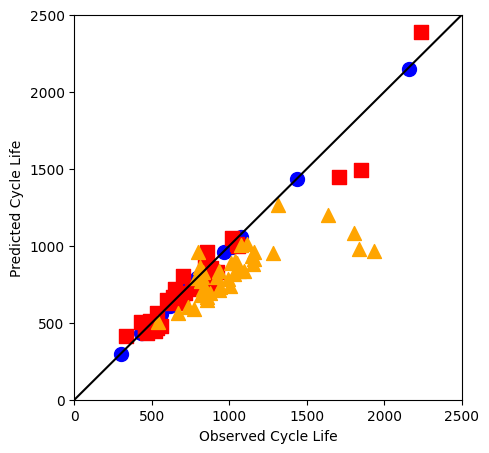

In [26]:
testALL(model)

################################################################################

# Repeat using only the first 40 cycles

################################################################################

In [27]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-40Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_40_10']

dismod_features=['minimum_dQ_40_10',
                 'variance_dQ_40_10',
                 'skewness_dQ_40_10',
                 'kurtosis_dQ_40_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_40_10',
               'variance_dQ_40_10',
               'Slope_Cap_Fade_2_40',
               'Intercept_Cap_Fade_2_40',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_40',
               'Min_IR',
               'Diff_IR_2_40']

In [28]:
#Use only the discharge model Tabular features
features = dismod_features #full_features
X_train=Training_Data[features].to_numpy()
X_test=Testing_Data[features].to_numpy()
X_sec=Secondary_Data[features].to_numpy()

#Scale
scaler = preprocessing.StandardScaler().fit(X_train)
Tabular_Train = scaler.transform(X_train)
Tabular_test = scaler.transform(X_test)
Tabular_sec = scaler.transform(X_sec)

In [29]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = train_Qdlin[:,:40,:]
test_Qdlin = test_Qdlin[:,:40,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,:40,:]

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(1.1242) tensor(-0.6322)
tensor(0.9673) tensor(-0.5410)
tensor(0.5148) tensor(-0.2270)
torch.Size([41, 40, 99])
torch.Size([42, 40, 99])
torch.Size([40, 40, 99])


In [30]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [31]:
torch.set_default_dtype(torch.float64)

In [32]:
train_Dataset = CustomDataset(train_Qdlin,y_train,Tabular_Train)
test_Dataset = CustomDataset(test_Qdlin,y_test,Tabular_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec,Tabular_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [33]:
epochs = 5000
learning_rate =.0001
weight_decay = .001

# Train & Test

In [34]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [35]:
criterion=nn.MSELoss()
model=CNN(40) #Using only the First 40 cycles
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=learning_rate)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 40, 99])
torch.Size([41, 1, 40, 99])
torch.Size([41, 16, 8, 23])
torch.Size([41, 2944])
torch.Size([41, 6])
torch.Size([41, 2944])
-- 0 -epoch--RMSE--  359.87355441048896
-- 100 -epoch--RMSE--  66.45426617454159
-- 200 -epoch--RMSE--  35.11283518362192
-- 300 -epoch--RMSE--  26.491453714266438
-- 400 -epoch--RMSE--  22.305292276113033
-- 500 -epoch--RMSE--  19.882368090822354
-- 600 -epoch--RMSE--  18.342753020808036
-- 700 -epoch--RMSE--  17.45440061971142
-- 800 -epoch--RMSE--  16.499649555995255
-- 900 -epoch--RMSE--  15.74439342158163
-- 1000 -epoch--RMSE--  19.032418104304625
-- 1100 -epoch--RMSE--  14.706774938008298
-- 1200 -epoch--RMSE--  14.519036321190203
-- 1300 -epoch--RMSE--  14.077299209502087
-- 1400 -epoch--RMSE--  13.63482099598864
-- 1500 -epoch--RMSE--  13.327732395145993
-- 1600 -epoch--RMSE--  13.618121746367038
-- 1700 -epoch--RMSE--  14.175774678166722
-- 1800 -epoch--RMSE--  12.80975420796717
-- 1900 -epoch--RMSE--  12.87712620162993
-- 2000 -epo

10.55807288423873 ---RMSE---Train
1.2467955273875533 ---MPE---Train
107.85314710317839 ---RMSE---Test
9.500970791737318 ---MPE---Test
227.46349242803126 ---RMSE---Test Secondary
17.561250798008196 ---MPE---Test Secondary


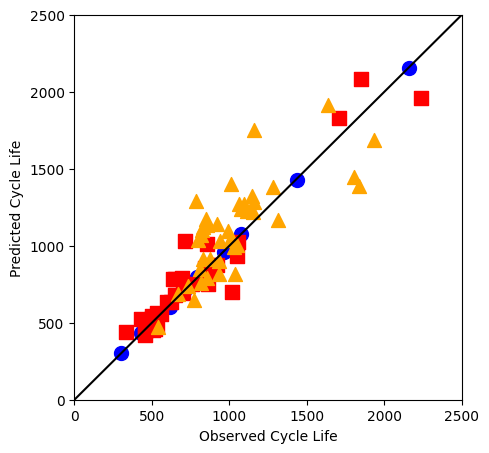

In [36]:
testALL(model)

################################################################################

# Repeat using only the first 20 cycles

################################################################################

In [37]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-20Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_20_10']

dismod_features=['minimum_dQ_20_10',
                 'variance_dQ_20_10',
                 'skewness_dQ_20_10',
                 'kurtosis_dQ_20_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_20_10',
               'variance_dQ_20_10',
               'Slope_Cap_Fade_2_20',
               'Intercept_Cap_Fade_2_20',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_20',
               'Min_IR',
               'Diff_IR_2_20']

In [38]:
#Use only the discharge model Tabular features
features = dismod_features #full_features
X_train=Training_Data[features].to_numpy()
X_test=Testing_Data[features].to_numpy()
X_sec=Secondary_Data[features].to_numpy()

#Scale
scaler = preprocessing.StandardScaler().fit(X_train)
Tabular_Train = scaler.transform(X_train)
Tabular_test = scaler.transform(X_test)
Tabular_sec = scaler.transform(X_sec)

In [39]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = train_Qdlin[:,:20,:]
test_Qdlin = test_Qdlin[:,:20,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,:20,:]

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(0.0264) tensor(-0.0102)
tensor(0.0276) tensor(-0.0079)
tensor(0.0151) tensor(0.0023)
torch.Size([41, 20, 99])
torch.Size([42, 20, 99])
torch.Size([40, 20, 99])


In [40]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [41]:
torch.set_default_dtype(torch.float64)

In [42]:
train_Dataset = CustomDataset(train_Qdlin,y_train,Tabular_Train)
test_Dataset = CustomDataset(test_Qdlin,y_test,Tabular_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec,Tabular_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [43]:
epochs = 5000
learning_rate =.0001
weight_decay = .001

# Train & Test

In [44]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [45]:
criterion=nn.MSELoss()
model=CNN(20) #Using only the First 20 cycles
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=learning_rate)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 20, 99])
torch.Size([41, 1, 20, 99])
torch.Size([41, 16, 3, 23])
torch.Size([41, 1104])
torch.Size([41, 6])
torch.Size([41, 1104])
-- 0 -epoch--RMSE--  331.7604247885115
-- 100 -epoch--RMSE--  325.55224461650545
-- 200 -epoch--RMSE--  290.70347902699024
-- 300 -epoch--RMSE--  199.53254495665476
-- 400 -epoch--RMSE--  156.78395440817036
-- 500 -epoch--RMSE--  125.42783742323374
-- 600 -epoch--RMSE--  105.11440037229767
-- 700 -epoch--RMSE--  94.57542554306725
-- 800 -epoch--RMSE--  85.1099962377484
-- 900 -epoch--RMSE--  73.8920002668539
-- 1000 -epoch--RMSE--  70.7816512946286
-- 1100 -epoch--RMSE--  69.65849115807258
-- 1200 -epoch--RMSE--  60.696925329505646
-- 1300 -epoch--RMSE--  59.01097718836816
-- 1400 -epoch--RMSE--  56.6581521731238
-- 1500 -epoch--RMSE--  53.912333159467025
-- 1600 -epoch--RMSE--  52.35168363483528
-- 1700 -epoch--RMSE--  51.90624064977333
-- 1800 -epoch--RMSE--  52.02798102741157
-- 1900 -epoch--RMSE--  49.14091657901533
-- 2000 -epoch--RMSE-

34.09385442586265 ---RMSE---Train
3.2550147159510407 ---MPE---Train
149.00439222534 ---RMSE---Test
11.579759706131393 ---MPE---Test
398.8311511282311 ---RMSE---Test Secondary
30.053274760011924 ---MPE---Test Secondary


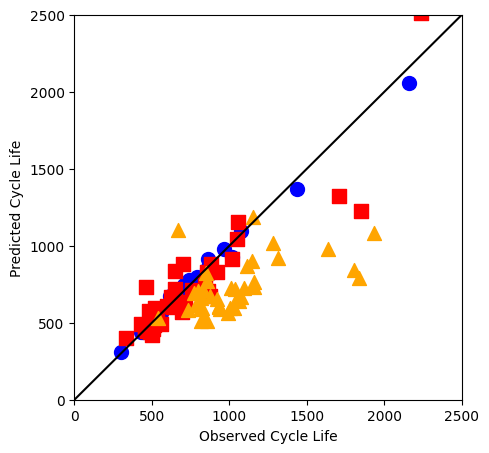

In [46]:
testALL(model)

In [47]:
pd.DataFrame({"Model":[ "CNN 100 cycles", "CNN 60 cycles","CNN 40 cycles","CNN 20 cycles"],
      "RMSE - Train": [RMSE[0],RMSE[3],RMSE[6],RMSE[9]],
      "RMSE - Test": [RMSE[1],RMSE[4],RMSE[7],RMSE[10]],
      "RMSE - Secondary test": [RMSE[2],RMSE[5],RMSE[8],RMSE[11]],
      "MPE - Train": [MPE[0],MPE[3],MPE[6],MPE[9]],
      "MPE - Test": [MPE[1],MPE[4],MPE[7],MPE[10]],
      "MPE - Secondary test": [MPE[2],MPE[5],MPE[8],MPE[11]]})  

,Model,RMSE - Train,RMSE - Test,RMSE - Secondary test,MPE - Train,MPE - Test,MPE - Secondary test
0,CNN 100 cycles,19,79,209,2,6,9
1,CNN 60 cycles,9,88,293,1,7,18
2,CNN 40 cycles,10,107,227,1,9,17
3,CNN 20 cycles,34,149,398,3,11,30
